# ProbaDingue : Using Probability to Trade

In [1]:
import numpy as np
import scipy.stats as sc
import matplotlib.pyplot as plt
import numba as nb

This note book constitutes a first approach to trading with probabilities. I will first try to develop a model based on the normal distribution before testing it against observable data. I will also try to make it a easy as possible to transition to more general distributions. 

Let's first get familiar with some functions from scipy, which offers a much broader number of functions that numpy.


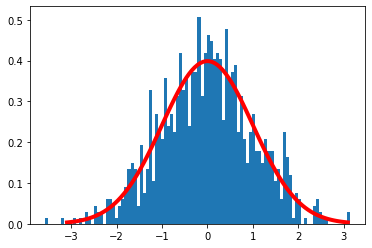

In [2]:
mu = 0
std = 1
n = 1000

x = np.linspace(sc.norm.ppf(0.001), sc.norm.ppf(0.999), 100)

rnd_sample_normal = sc.norm.rvs(size=n)

fig, ax = plt.subplots(1,1,figsize=(6, 4))
ax.hist(rnd_sample_normal, bins=100, density=True)
ax.plot(x, sc.norm.pdf(x), 'r', lw=4)

The basic idea of building a trading strategy with probabilities lies on the fact that we assume each log returns of the price to follow a particular distribution. We begin with the normal distribution to construct the foundations of the model before applying it to more reasonable distribution i.e. student distribution. The aim will be to characterize the dependence between those random variables and try understand the underlying dynamics of the log returns. In order to understand those dynamics we will make some simulation with some well-known model namely AR, and MA model with and without ARCH or GARCH components. we will compare those simulations with observable data and improve the model by analysing the descrepancies.

## The basic idea

Let $X_{t} \sim \mathcal{N}(\mu, \sigma^2)$ be a random variable representing the log return of a price. We will first assume $\mu = 0$ without loss of generality. From that random variable we define another random variable $S_t$ namely the sum of the next $N$ log returns from time $t$ and onwards. This r.v. is defined as follows, 

$$ S_{t;N} = \sum\limits_{n=0}^{N-1} X_{t+n} $$

If we assume $X_t$ to be independent through time, then the distribution of $S_{t;N}$ would straightforwardly be $\mathcal{N}(0, \sum_{n=0}^{N-1} \sigma^2)$

However, we know from empirical evidence that $X_t$ is not independent through time, if it is not through the first moment (mean) it can be through the second moment (variance) — i.e. log returns may not be correlated (AR model) but the squared log return may be (ARCH model).

In full generality, we first don't assume any functional form on the dependence of the $X_t$. For instance, if we create a random vector with $N$ elements $X_t$, we obtain

$$ X_{N} = (X_0, \cdots, X_{t+N-1})^{\top} \sim \mathcal{N}_N (0, \Sigma_X)$$

This vector follows a multivariate normal distribution, which is fully characterized by its mean and covariance structure. This allows us to take into account the dependence between different time of the random variable $X_t$.

Given the dependence structure, we can redefine the random variable $S_{t;N}$ to follow the normal distribution $\mathcal{N}(0, \sum_{n=0}^{N-1}\sum_{m}^{N-1}\sigma_{n,m})$ where $\sigma_{n,m}$ is the $(n,m)$ element of the covariance matrix $\Sigma_X$. Note that the element on the diagonal — i.e. $n=m$, is the variance.

I believe that defining such a random variable $S_{t;N}$ is key for constructing a trading strategy since it allows to another important random variable $Y_{t;N,\alpha}$ defined as follows, 

$$ Y_{t;N, \alpha} = \mathbb{1}_{S_{t;N} \geq \alpha} $$

where $\mathbb{1}_A$ is the indicator function that takes value $1$ if the event A is true and $0$ otherwise, $\alpha$ is a given threshold.

This r.v. $Y_{t;N, \alpha}$ allows us to define when we should open a position and when we should not. In other words, when the sum of the next $N$ log return is above a given threshold, we should buy the underlying asset since its price will increase in the next $N$ periods compared to now.


We can also obtain the probability that the price will increase in the next $N$ periods :

\begin{align} 
    \mathbb{P}(Y_{t;N,\alpha} = 1) := \mathbb{E}(Y_{t;N, \alpha}) &= \mathbb{E}(\mathbb{1}_{S_{t;N} \geq \alpha})\\
                                           &=  \mathbb{P}(S_{t;N} \geq \alpha) \\
                                           &= \mathbb{P}(\sum\limits_{n=0}^{N-1} X_{t+n} \geq \alpha)
\end{align}

### Example with Moving Average model

Let's know consider the random variable $X_t$ to follow a MA model. For simplicity we assume the MA to be of order 1.

\begin{align}
    X_t = \epsilon_t + \theta \epsilon_{t-1} && \text{ where } \epsilon_t \sim GWN(0, \sigma_\epsilon^2)
\end{align}

The covariance structure between successive random variables is as follows :

\begin{align}
    \mathbb{C}ov(X_t, X_{t+n}) = 
        \begin{cases}
            (1 + \theta^2) \sigma_\epsilon^2 & \text{ if } n = 0\\
            \theta \sigma_\epsilon^2 & \text{ if } n = 1\\
            0 & \text{ otherwise }
        \end{cases}
\end{align}

We thus get a more precise characterization of $S_{t;N} \sim \mathcal{N}\Big(0, \sigma_S^2\Big)$ where $\sigma_S^2 = \sigma_\epsilon^2 \big[ N\theta^2 + 2(N-1)\theta + N \big]$

Let construct a function allowing us to get a sample from a MA process of order 1. Note that this function is an infinite generator that will allow to get one unique sample when we call the function.

In [3]:
# The first lines of a process are used to initialise the model. 
# Here with a MA(1) we only need the previous obs. (which we don't have if we just started the process)
def MA(theta:np.float64):
    previous_innov = np.random.normal(0,1)
    
    while True:
        current_innov = np.random.normal(0,1)
        yield current_innov + theta * previous_innov
        previous_innov = current_innov

To get a sample of $T$ points we use another function. This latter function could also be reused when dealing with more complex models.

In [4]:
def sample_process(process, params:np.ndarray, n:int):
    sample = np.empty((n, ), dtype=np.float64)
    process = process(*params)
    
    for i in range(n):
        sample[i] = next(process)
    
    return sample

Take two sample from two different MA process.

In [5]:
theta1 = 0.7
theta2 = -0.5

sample1 = sample_process(MA, [theta1], 10000)
sample2 = sample_process(MA, [theta2], 10000)

Let's create a function that will compute the random variable $S_{t;N}$ given an sample array and an order $N$.

In [6]:
# Rolling sum with N terms
def S_sum(sample_array:np.ndarray, N:int):
    sample_sum = np.cumsum(sample_array)
    return sample_sum[N:] - sample_sum[:-N]

In [196]:
def S_var(N:int, theta:np.float64):
    return N*(theta**2) + 2*(N-1)*theta + N

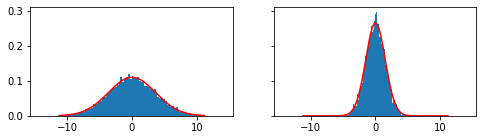

In [179]:
N = 5
S1 = S_sum(sample1, N)
S2 = S_sum(sample2, N)

fig, ax = plt.subplots(1, 2, figsize=(8, 2), sharex=True, sharey=True)
ax = np.ravel(ax)
_, _, _ = ax[0].hist(S1, bins=100, density=True)
_, _, _ = ax[1].hist(S2, bins=100, density=True)


theor_sigma1 = np.sqrt(S_var(N, theta1))
theor_sigma2 = np.sqrt(S_var(N, theta2))
x = np.linspace(sc.norm.ppf(0.001, 0, theor_sigma1), sc.norm.ppf(0.999, 0, theor_sigma1), 200)
ax[0].plot(x, sc.norm.pdf(x, 0, theor_sigma1), 'r')
ax[1].plot(x, sc.norm.pdf(x, 0, theor_sigma2), 'r')

We can see that the theoretical distribution of $S_{t;N}$ is correct according to the simulation. 

Note also that when the more positive the parameter of the MA process, the larger the variance of the sum. Conversely, the more negative the coefficient, the narrower the distribution.

From there, we can define the Bernoulli process $Y_{t;N, \alpha}$ by choosing a threshold $\alpha$.
For instance, choose $\alpha$ such that 10% of the observations are greater then $\alpha$. In order words, choose $\alpha$ to be the 0.9 quantile of the normal distribution. This leads $Y_{t;N, \alpha}$ to follow a Bernoulli process with $p = 0.1$.

In [197]:
def getThreshold(N:int, theta:np.float64, percentile:np.float64):
    std = np.sqrt(S_var(N, theta))
    return sc.norm.ppf(percentile, 0, std)

In [184]:
thresh = getThreshold(N, theta1, 0.9)
thresh

4.6295773152313915

## Conditional distributions of the $Y_{t;N, \alpha}$ process

If it is believe that previous observations are informative for the current and future ones, conditioning on them could lead to a better adjustments of the parameter of the model.

For instance, we can get a conditional distribution for the parameter $p$ of the Bernoulli process $Y_{t;N, \alpha}$.

\begin{align}
    \mathbb{P} \big(Y_{t;N, \alpha} = 1 | Y_{t-1;N, \alpha} = 1 \big) &= \mathbb{P}\big(S_{t;N} \geq \alpha \: \big| \: S_{t-1;N} \geq \alpha \big)\\
                                                &= \frac{\mathbb{P}\big(S_{t;N} \geq \alpha \: , \: S_{t-1;N} \geq \alpha \big)}{\mathbb{P}\big(S_{t-1;N} \geq \alpha \big)} && \text{(def. of conditional distrib.)}
\end{align}

We only need to find an expression for the multivariate distribution on the numerator.

We know that this multivariate distribution is normal (since it comes from two normal). We are also able to compute the covariance between $S_{t;N}$ and $S_{t-1;N}$ given the definition of the r.v. We thus have all the ingredients to express the multivariate distribution

By using the definition of the r.v. $S_{t;N}$ and the matrix representation of the double sum, we obtain, 

\begin{align}
    \sigma_{SS}:=\mathbb{E}\big( S_{t;N}S_{t-1, N} \big) &= \sum\limits_{n=0}^{N-1} \sum\limits_{m=0}^{N-1} \mathbb{E}(X_{t+n}X_{t+m-1})\\
                                            &= \sum\limits_{n=0}^{N-2} \sum\limits_{m=0}^{N-2} \mathbb{E}(X_{t+n}X_{t+m}) + \sum\limits_{n=0}^{N-1}\mathbb{E}(X_{t-1}X_{t+n}) + \sum\limits_{m=0}^{N-1} \mathbb{E}(X_{t+N-1}X_{t+n-1}) - \mathbb{E}(X_{t+N-1}X_{t-1})
\end{align}

We then have $(S_{t;N}, S_{t-1;N})^\top \sim \mathcal{N}_2\left( 0, \begin{pmatrix} \sigma_S^2 & \sigma_{SS} \\  \sigma_{SS} & \sigma_S^2 \end{pmatrix} \right)$.

### Example with MA model

The covariance betwee $S_{t;N}$ and $S_{t-1;N}$ has a clean formula in the case of the MA(1) given by,

$$ \mathbb{E}\big( S_{t;N}S_{t-1,N} \big) = (N-1)(\theta +1)^2 \sigma_{\epsilon}^2 $$

Now we need the probability that the multivariate normal is greater than our threshold $\alpha$. However even in the case of the 2-dimensional multivariate normal, it is not an easy task. Therefore we will use Monte Carlo methods to get an estimate of the probability. We could have used build-in methods of scipy, however we would not avoid the Monte Carlo simulation for more general probability distributions.

In [168]:
# args = (mean:np.ndarray, cov:np.ndarray)
@nb.njit()
def multivariate_normal(x:np.ndarray, *args):
    mean, cov = args
    norm_const = 2.0 * np.pi * np.sqrt(np.linalg.det(cov))
    quadratic = (np.dot((x - mean.reshape(-1,1)).T, np.linalg.inv(cov)) * (x - mean.reshape(-1,1)).T).sum(axis=-1)
    exp = np.exp(-0.5 * quadratic)
    return exp / norm_const

In [162]:
# "func" must be capable of receiving an array (#coords, n_sample) (to make use of numpy vectorization)
def Integrate_Carlo(func, n:np.int64, a:np.ndarray, b:np.ndarray, *args):
    x = np.empty((len(a),n), dtype=np.float64)
    for i in range(len(a)):
        x[i, :] = np.random.uniform(a[i], b[i], n)

    return np.mean(func(x, *args)) * np.prod(b-a)

Now we can estimate an interval on a multivariate normal distribution. 

In [169]:
a = np.array([thresh,thresh], dtype=np.float64)
b = np.array([thresh*10.,thresh*10.], dtype=np.float64)
cov_S = (N-1)*(theta1+1)**2

mean = np.array([0.,0.], dtype=np.float64)
cov = np.array([np.array([theor_sigma1**2,cov_S]),np.array([cov_S,theor_sigma1**2])], dtype=np.float64)

joint1 = Integrate_Carlo(multivariate_normal, 10000000, a, b, mean, cov)
joint1

<ipython-input-168-20192a0876dc>:6: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 2d, A))
  quadratic = (np.dot((x - mean.reshape(-1,1)).T, np.linalg.inv(cov)) * (x - mean.reshape(-1,1)).T).sum(axis=-1)


0.06650093715353043

Finally we can estimate the conditional probability above.

In [12]:
joint1 / (1.0 - sc.norm.cdf(thresh, 0, theor_sigma1))

0.6677695239422738

From there, we can define a markov chain with all the possible transitions given the last state. 

For instance, if the parameters are $N=5$, $tresh = 90th$ percentile and $\theta = 0.7$ we get the following markov chain :

\begin{align}
    P_{y_t, y_{t-1}} = 
        \begin{pmatrix}
            0.9635 & 0.0365 \\
            0.3318   & 0.6682
        \end{pmatrix}
\end{align}

We can clearly see that the markov chain stays most of the time in the $(Y_t = 0 | Y_{t-1} = 0)$ state meaning that trading does not occur frequently, which may be reassuring if we consider the transaction costs. However once a trade is initiated there is a better probability to keep trading, at least better than fair odds. In other words, once a position is opened there is a 33% probability to close the position the next period.

We can get the stationary distribution this markov chain by exponentiating the matrix by a large number. This stationary distribution gives us the probability to be at one given state at any time, i.e. unconditionally of the previous state. Observe that the probability of being at the state $Y_{t;N,\alpha} = 1$ is determined by the threshold namely the 90th percentile here. Also note that with the markov chain we obtain a decomposition of the initial probability for the r.v. $Y_{t;N,\alpha}$

In [175]:
np.linalg.matrix_power(np.array([[0.9635, 0.0365],[0.3318, 0.6682]]), 5)

array([[0.91086487, 0.08913513],
       [0.81027497, 0.18972503]])

Note that given the definition of the random variable $S_{t;N}$ the current state does not only depend on the previous state but also on the $N$ last states. This would then give us a 'N-th' order markov chain. We will explore those extra dependencies later.

Let's get a function that gives us the markov chain when given the parameters

In [208]:
# 'percentile' parameter is the percentile of the r.v. S used for the threshold
def Markov_MA(N:int, theta:np.float64, percentile:np.float64):
    thresh = getThreshold(N, theta, percentile)
    var = S_var(N, theta)
    cov_S = (N-1)*(theta+1)**2
    
    mean = np.array([0.,0.], dtype=np.float64)
    cov = np.array([np.array([var,cov_S]),np.array([cov_S,var])], dtype=np.float64)
    
    a = np.array([thresh,thresh], dtype=np.float64)
    b = np.array([thresh*10.,thresh*10.], dtype=np.float64)
    joint11 = Integrate_Carlo(multivariate_normal, 10000000, a, b, mean, cov)
    
    a = np.array([-thresh*10.,-thresh*10.], dtype=np.float64)
    b = np.array([thresh,thresh], dtype=np.float64)
    joint00 = Integrate_Carlo(multivariate_normal, 10000000, a, b, mean, cov)
    
    condi00 = joint00 / sc.norm.cdf(thresh, 0, np.sqrt(var))
    condi11 = joint11 / (1.0 - sc.norm.cdf(thresh, 0, np.sqrt(var)))
    
    return np.array([[condi00, 1.0-condi00], [1.0-condi11, condi11]], dtype=np.float64)

In [213]:
Markov_MA(5, 0.0, 0.9)

array([[0.95050276, 0.04949724],
       [0.43753876, 0.56246124]])

## Trading based on the Markov Chain

Now that we are able to create simple markov chain with an MA(1) model, we will try to develop a simple trading strategy around it.

The strategy will consist in observing the last $N + 1$ returns and take a decision based on them. Note that we take $N + 1$ previous observations to take a decision at time $t$ since the random variable $S_{t;N}$ is composed of a sum of $N$ r.v. $X_t$. The $N$ last r.v. $S_{t;N}$ are not observed since there are some terms of the sum that are still not observed at time $t$. Therefore we must take $N + 1$ observations and try to infer what is the probability that the current $S_{t;N}$ is above the threshold. 

In [223]:
# When we buy we keep the position during N periods. However it is possible to have multiple position at the same time.
# Therefore we need to add those overlapping position. But each position must have its own lifespan.
# 'Position' argument must be an array with 1 when we buy and 0 otherwise
def getOverlappingPosition(N:int, position:np.ndarray):
    overlappingPosition = np.zeros((len(position)+N,), dtype=np.float64)
    for t in range(len(position)):
        if position[t] == 1.0:
            overlappingPosition[t:t+N] += 1.0
    return overlappingPosition[:-N]

In [227]:
def getEquityCurve(N:int, position:np.ndarray, return_hist:np.ndarray):
    overlappingPosition = getOverlappingPosition(N, position)
    return overlappingPosition * return_hist

[[0.90195562 0.09804438]
 [0.90150518 0.09849482]]


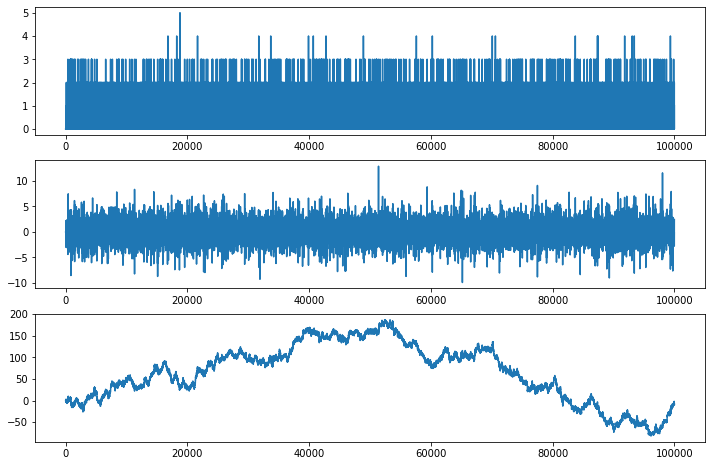

In [258]:
def trading_process(length:int, N:int, theta:np.float64, percentile:np.float64):
    thresh = getThreshold(N, theta, percentile)
    price_process = MA(theta)
    markov = np.linalg.matrix_power(Markov_MA(N, theta, percentile), N)
    print(markov)
    
    return_hist = np.empty((length,), dtype=np.float64)
    S_hist = np.empty((length,), dtype=np.float64)
    Y_hist = np.empty((length,), dtype=np.float64)
    pos_hist = np.empty((length,), dtype=np.float64)
    
    for t in range(length):
        return_hist[t] = next(price_process)
        if t < N:
            S_hist[t] = 0.0
            Y_hist[t] = 0.0
            pos_hist[t] = 0.0
            continue
        
        S_hist[t] = np.sum(return_hist[t-N-1:t]) # Valeur de la r.v. S en 't-N', pas l'actuel donc
        Y_hist[t] = (S_hist[t] >= thresh)*1.0 # Valeur de Y il y a N period, pas l'actuel donc
        
#         p = markov[int(Y_hist[t]), 1] 
        p = markov[1,1] if Y_hist[t] == 1.0 else markov[0,1] # Choose the right proba of winning today given the r.v. Y, N periods ago.
        
        
        pos_hist[t] = (np.random.uniform(0,1) <= p)*1.0
        
    return return_hist, pos_hist, Y_hist


length = 100000
N = 5
theta = -0.5
percentile = 0.9

return_hist, pos_hist, y_hist = trading_process(length, N, theta, percentile)

equityCurve = getEquityCurve(N, pos_hist, return_hist)

fig, ax = plt.subplots(3,1,figsize=(12, 8))
ax = np.ravel(ax)
ax[0].plot(getOverlappingPosition(N, pos_hist))
ax[1].plot(equityCurve)
ax[2].plot(np.cumsum(equityCurve))

## Determine the optimal parameter : $N$

In order to find an optimal parameter we need a criterion. What we know upto now about the parameter $N$ is that it is the basis for determining the random variable $Y_t$. It is directly related to the variance and covariances of the random variables $Y_{t;N,\alpha}$. Note that we cannot let $N$ tend to $\infty$ since it will imply infinite variance and covariances (which is not permitted in Hilbert space).

We believe that the optimal $N$ is naturally determined by the trade frequency. A lower threshold will imply a higher trading frequency. Conversely, a higher threshold will imply a lower trade frequency.

$N$ must also be dependent on the length of trends on a given stock. Since longer trends will imply higher $N$. It is common sense to believe that trends are finite, hence $N$ also is.

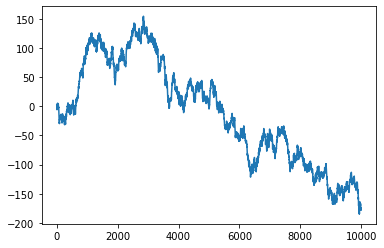

In [17]:
N2 = 20
sample_path = sample_process(MA, [0.9], 10000)
plt.plot(np.cumsum(sample_path))
# S = S_sum(sample_path, N)
# _, _, _ = plt.hist(S, bins=100, density=True)

Unconditionally my probability of winning is 10% (when the threshold is set to the 90th percentile) and my average winning is the mean of the truncated normal from the 90th percentile to $\infty$. Analogously when I lose.

Questions : conditionally on the fact that I won last period, what is my avg winning overall ? per period ? (same for when conditional on losing).

Question : Given that I have won last period, if I win today, how much can I expect to win ? to lose ? (and if I have lost last period ?). We believe we can answer that question with the expectation of truncated multivariate distribution (via monte carlo integration)